# 5-1. Dataset和DataLoader
Pytorch通常使用Dataset和DataLoader这两个工具类来构建数据管道。

Dataset定义了数据集的内容, 它相当于列表这种数据结构, 具有一定的长度, 能够通过索引获取数据集中的元素。

而DataLoader定义了按batch加载数据集的方法, 它是一个实现了iter方法的可迭代对象, 每次迭代输出一个batch的数据。

DataLoader能够控制batch的大小, batch中元素的采样方法, 以及将batch结果整理成模型输入形式的方法, 并且可以使用多进程读取数据。

在绝大部分情况下, 用户只需要实现Dataset的len和getitem方法, 就可以轻松构建自己的数据集, 并用默认管道进行加载。

## 一，Dataset和DataLoader概述


**1，获取一个batch数据的步骤**


让我们考虑一下从一个数据集中获取一个batch的数据需要哪些步骤。

(假定数据集的特征和标签分别表示为张量`X`和`Y`，数据集可以表示为`(X,Y)`, 假定batch大小为`m`)

1，首先我们要确定数据集的长度`n`。

结果类似：`n = 1000`。

2，然后我们从`0`到`n-1`的范围中抽样出`m`个数(batch大小)。

假定`m=4`, 拿到的结果是一个列表，类似：`indices = [1,4,8,9]`

3，接着我们从数据集中去取这`m`个数对应下标的元素。

拿到的结果是一个元组列表，类似：`samples = [(X[1],Y[1]),(X[4],Y[4]),(X[8],Y[8]),(X[9],Y[9])]`

4，最后我们将结果整理成两个张量作为输出。

拿到的结果是两个张量，类似`batch = (features,labels) `， 

其中 `features = torch.stack([X[1],X[4],X[8],X[9]])`

`labels = torch.stack([Y[1],Y[4],Y[8],Y[9]])`


```python

```

**2，Dataset和DataLoader的功能分工**


上述第1个步骤确定数据集的长度是由 Dataset的`__len__` 方法实现的。

第2个步骤从`0`到`n-1`的范围中抽样出`m`个数的方法是由 DataLoader的 `sampler`和 `batch_sampler`参数指定的。

`sampler`参数指定单个元素抽样方法，一般无需用户设置，程序默认在DataLoader的参数`shuffle=True`时采用随机抽样，`shuffle=False`时采用顺序抽样。

`batch_sampler`参数将多个抽样的元素整理成一个列表，一般无需用户设置，默认方法在DataLoader的参数`drop_last=True`时会丢弃数据集最后一个长度不能被batch大小整除的批次，在`drop_last=False`时保留最后一个批次。

第3个步骤的核心逻辑根据下标取数据集中的元素 是由 Dataset的 `__getitem__`方法实现的。

第4个步骤的逻辑由DataLoader的参数`collate_fn`指定。一般情况下也无需用户设置。

```python

```

**3，Dataset和DataLoader的主要接口**


以下是 Dataset和 DataLoader的核心接口逻辑伪代码，不完全和源码一致。

```python
import torch 
class Dataset(object):
    def __init__(self):
        pass
    
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self,index):
        raise NotImplementedError
        

class DataLoader(object):
    def __init__(self,dataset,batch_size,collate_fn,shuffle = True,drop_last = False):
        self.dataset = dataset
        self.sampler =torch.utils.data.RandomSampler if shuffle else \
           torch.utils.data.SequentialSampler
        self.batch_sampler = torch.utils.data.BatchSampler
        self.sample_iter = self.batch_sampler(
            self.sampler(range(len(dataset))),
            batch_size = batch_size,drop_last = drop_last)
        
    def __next__(self):
        indices = next(self.sample_iter)
        batch = self.collate_fn([self.dataset[i] for i in indices])
        return batch
    
```

## 二、使用Dataset创建数据集
Dataset创建数据集常用的方法有: 
* 使用torch.utils.data.TensorDataset根据Tensor创建数据集
* 使用torchvision.datasets.ImageFolder根据图片目录创建数据集
* 继承torch.utils.data.Dataset创建自定义数据集

此外还可以通过：
* torch.utils.random_split将一个数据集分割成多份
* 调用Dataset的加法将多个数据集合并

### 1.根据Tensor创建数据集

In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split

In [2]:
# 根据Tensor创建数据集
from sklearn import datasets
iris = datasets.load_iris()
ds_iris = TensorDataset(torch.Tensor(iris.data), torch.Tensor(iris.target))

In [3]:
print(type(ds_iris))

<class 'torch.utils.data.dataset.TensorDataset'>


In [4]:
# 分割成训练集和测试集
n_train = int(len(ds_iris) * 0.8)
n_test = len(ds_iris) - n_train
ds_train, ds_test = random_split(ds_iris, [n_train, n_test])

In [5]:
print(type(ds_train))
print(type(ds_test))

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [6]:
#  使用DataLoader加载数据
dl_train, dl_test = DataLoader(ds_train, batch_size=8), DataLoader(ds_test, batch_size=8)

In [7]:
for features, labels in dl_train:
    print(features, labels)
    break

tensor([[5.0000, 3.5000, 1.6000, 0.6000],
        [6.9000, 3.1000, 4.9000, 1.5000],
        [7.2000, 3.0000, 5.8000, 1.6000],
        [6.3000, 3.4000, 5.6000, 2.4000],
        [6.9000, 3.1000, 5.1000, 2.3000],
        [5.6000, 2.8000, 4.9000, 2.0000],
        [4.8000, 3.0000, 1.4000, 0.1000],
        [6.7000, 3.1000, 4.4000, 1.4000]]) tensor([0., 1., 2., 2., 2., 2., 0., 1.])


In [8]:
# 演示加法运算符（`+`）的合并作用
ds_data = ds_train + ds_test
print(type(ds_data))

<class 'torch.utils.data.dataset.ConcatDataset'>


### 2.根据图片目录创建图片数据集

In [9]:
from torchvision import transforms, datasets

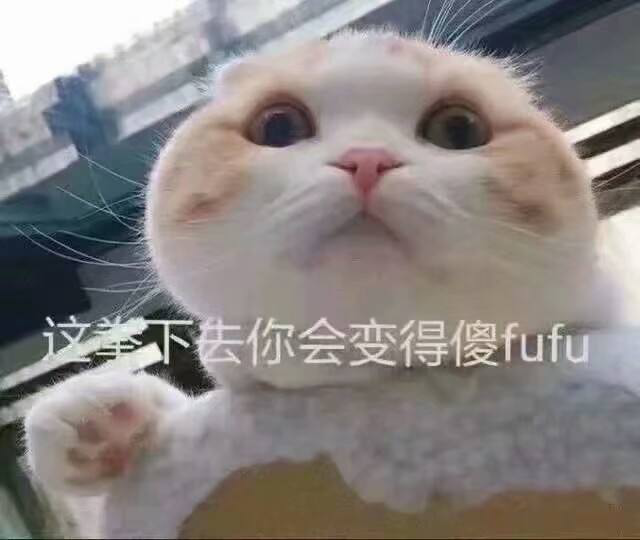

In [10]:
from PIL import Image
img = Image.open("./data/cat.jpeg")
img

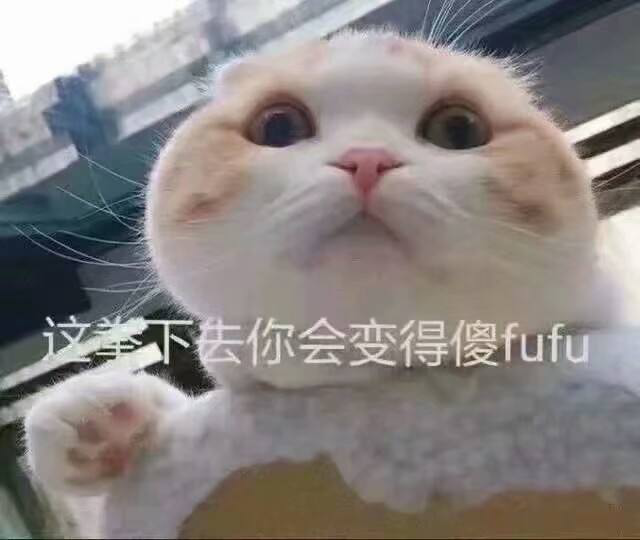

In [11]:
# 随机数值翻转
transforms.RandomVerticalFlip()(img)

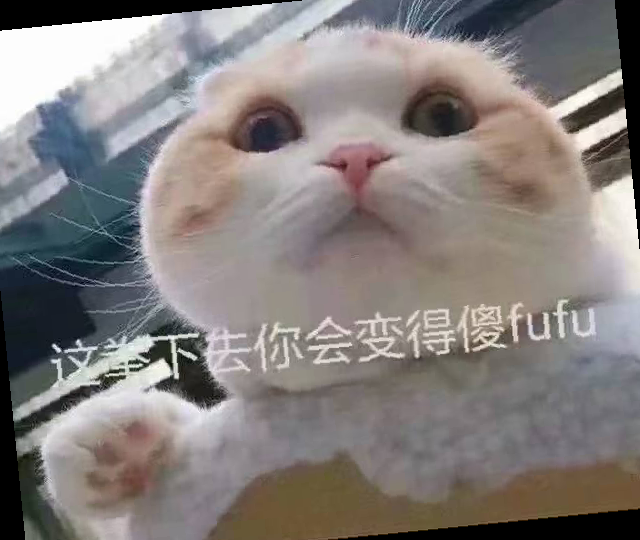

In [12]:
# 随机旋转
transforms.RandomRotation(45)(img)

In [13]:
# 定义图片增强操作

transform_train = transforms.Compose([
   transforms.RandomHorizontalFlip(), #随机水平翻转
   transforms.RandomVerticalFlip(), #随机垂直翻转
   transforms.RandomRotation(45),  #随机在45度角度内旋转
   transforms.ToTensor() #转换成张量
  ]
) 

transform_test = transforms.Compose([
    transforms.ToTensor()
  ]
)

In [15]:
# 根据图片目录创建数据集
ds_train = datasets.ImageFolder("./data/cifar2/train",
                                transform=transform_train, target_transform=lambda t: torch.tensor([t]).float())
ds_test = datasets.ImageFolder("./data/cifar2/test",
                               transform=transform_test, target_transform=lambda t: torch.tensor([t]).float())


In [16]:
print(ds_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [17]:
# 使用DataLoader加载数据集

dl_train = DataLoader(ds_train, batch_size=8, shuffle = True, num_workers=3)
dl_test = DataLoader(ds_test, batch_size=8, shuffle = True, num_workers=3)

In [18]:
for features,labels in dl_train:
    print(features.shape)
    print(labels.shape)
    break

torch.Size([8, 3, 32, 32])
torch.Size([8, 1])


### 3.创建自定义数据集

## 三、使用DataLoader加载数据集

DataLoader的函数签名如下：
```python
DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    sampler=None,
    batch_sampler=None,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
    drop_last=False,
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
)
```